In [2]:
!pip install -qq transformers
!pip install -qq torchflare

     |████████████████████████████████| 2.5MB 14.9MB/s 
     |████████████████████████████████| 3.3MB 51.1MB/s 
     |████████████████████████████████| 901kB 47.2MB/s 
     |████████████████████████████████| 92kB 7.6MB/s 
     |████████████████████████████████| 10.3MB 17.9MB/s 
     |████████████████████████████████| 3.0MB 53.5MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 9.9MB 44.8MB/s 
     |████████████████████████████████| 735.5MB 23kB/s 
     |████████████████████████████████| 71kB 11.5MB/s 
     |████████████████████████████████| 51.0MB 119kB/s 
     |████████████████████████████████| 22.3MB 72.3MB/s 
     |████████████████████████████████| 15.3MB 336kB/s 
     |████████████████████████████████| 17.3MB 314kB/s 
     |████████████████████████████████| 38.2MB 92kB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.8.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, bu

In [1]:
import sklearn.metrics as skm
import pickle
import torch 
import transformers 
from torchflare.datasets import TextDataloader
import pandas as pd 
import glob
from torchflare.experiments import to_device

In [2]:
test_df = pd.read_csv("/content/drive/MyDrive/Hahakathon/gold-test-27446.csv")

In [5]:
class BackBoneModel(torch.nn.Module):
    def __init__(self, out_features, model_path):
        super(BackBoneModel, self).__init__()
        self.model = transformers.AutoModel.from_pretrained(
            model_path, return_dict=False
        )
        in_features = self.model.pooler.dense.out_features
        self.linear = torch.nn.Linear(in_features, out_features)
        #self.dropout = torch.nn.Dropout(0.2)

    def forward(self, x):

        _, o_2 = self.model(**x)
        #op = op.last_hidden_state[:, 0]
        #op = self.dropout(o_2)
        op = self.linear(o_2)
        return op

In [6]:
model_files = [path for path in glob.glob("/content/drive/MyDrive/Hahakathon/*.bin") if bool("humour" not in path)]

In [10]:
def inference(model, test_dl):
    op = []
    for batch in test_dl:
        batch = to_device(batch , "cuda")
        preds = model(batch)
        op.extend(torch.argmax(preds , dim = 1).cpu().numpy())
    return op

In [11]:
for model_path in model_files:
    name = model_path.split("/")[-1].split(".")[0]
    backbone_name = "prajjwal1/" +name
    
    tokenizer = transformers.AutoTokenizer.from_pretrained(backbone_name)
    test_dl = TextDataloader.from_df(
                df=test_df,
                input_col="text",
                label_cols=None,
                tokenizer=tokenizer,
                max_len=256,
            ).get_loader(batch_size=16, shuffle = False)
    model = BackBoneModel(out_features=2, model_path=backbone_name)
    model = model.to("cuda")
    ckpt = torch.load(model_path)
    model.load_state_dict(ckpt["model_state_dict"])
    op = inference(model, test_dl)
    print(f"Model : {name} | F1-Score(Test) : {skm.f1_score(test_df.is_humor.values , op)}")



Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model : bert-medium | F1-Score(Test) : 0.9259560618388933


Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model : bert-small | F1-Score(Test) : 0.9260143198090692


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Model : bert-tiny | F1-Score(Test) : 0.8717532467532467


In [20]:
pkl_files = glob.glob("/content/drive/MyDrive/Hahakathon/*.pkl")


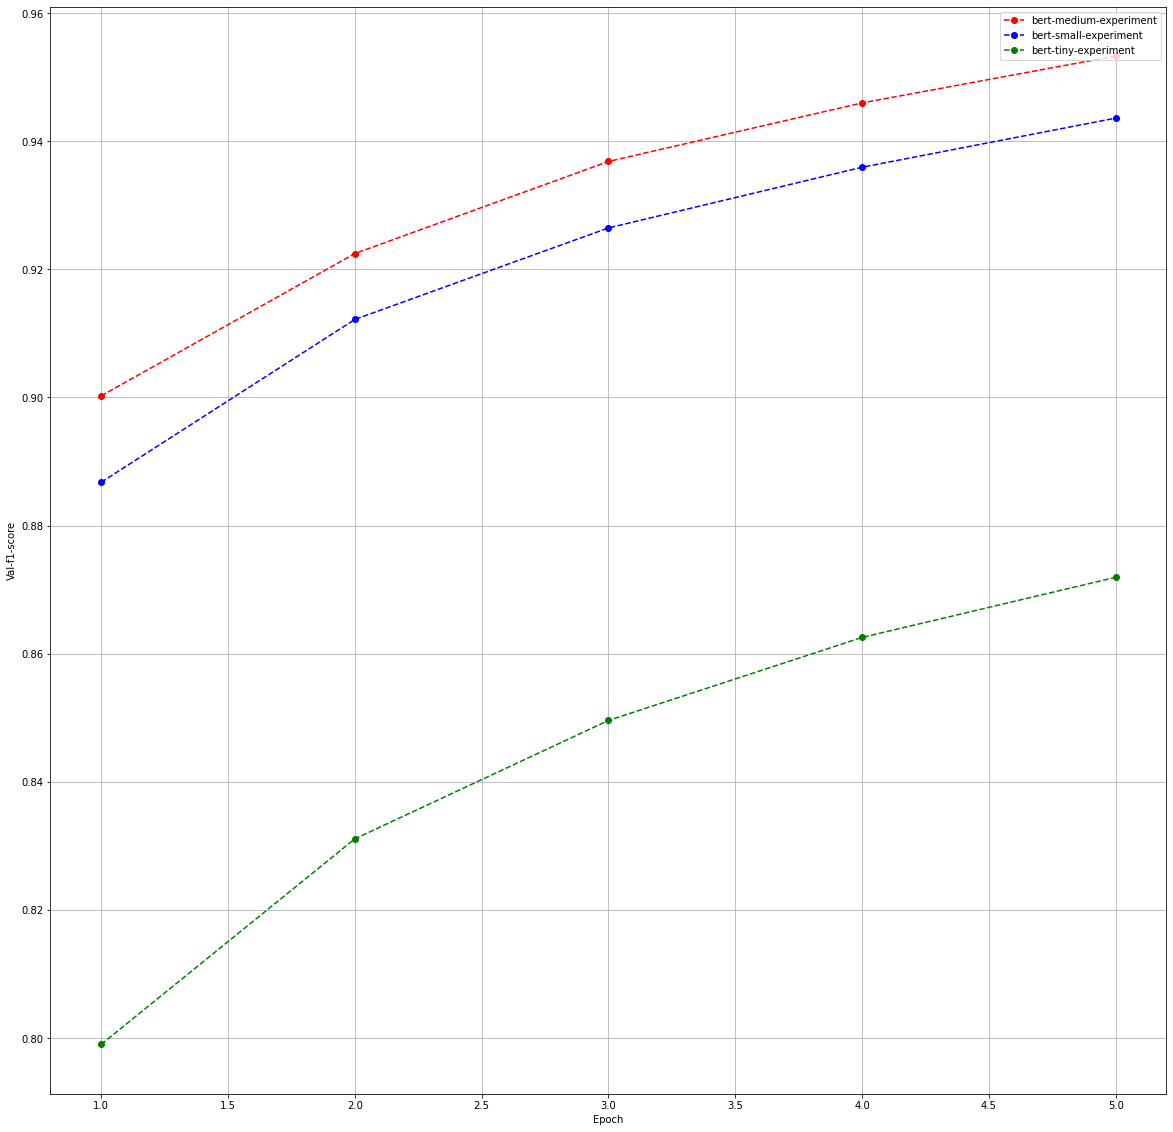

In [25]:
import matplotlib.pyplot as plt

markers_list = ["ro--" , "bo--" , "go--"]
plt.figure(figsize=(20,20))
plt.grid(True)
for marker , file_path in zip(markers_list , pkl_files):
    history = pickle.load(open(file_path , "rb"))
    plt.plot(history["Epoch"] , history["val_f1_score"] , marker , label = file_path.split("/")[-1].split(".")[0])
    plt.xlabel("Epoch")
    plt.ylabel("Val-f1-score")
plt.legend(loc='upper right')
plt.show()


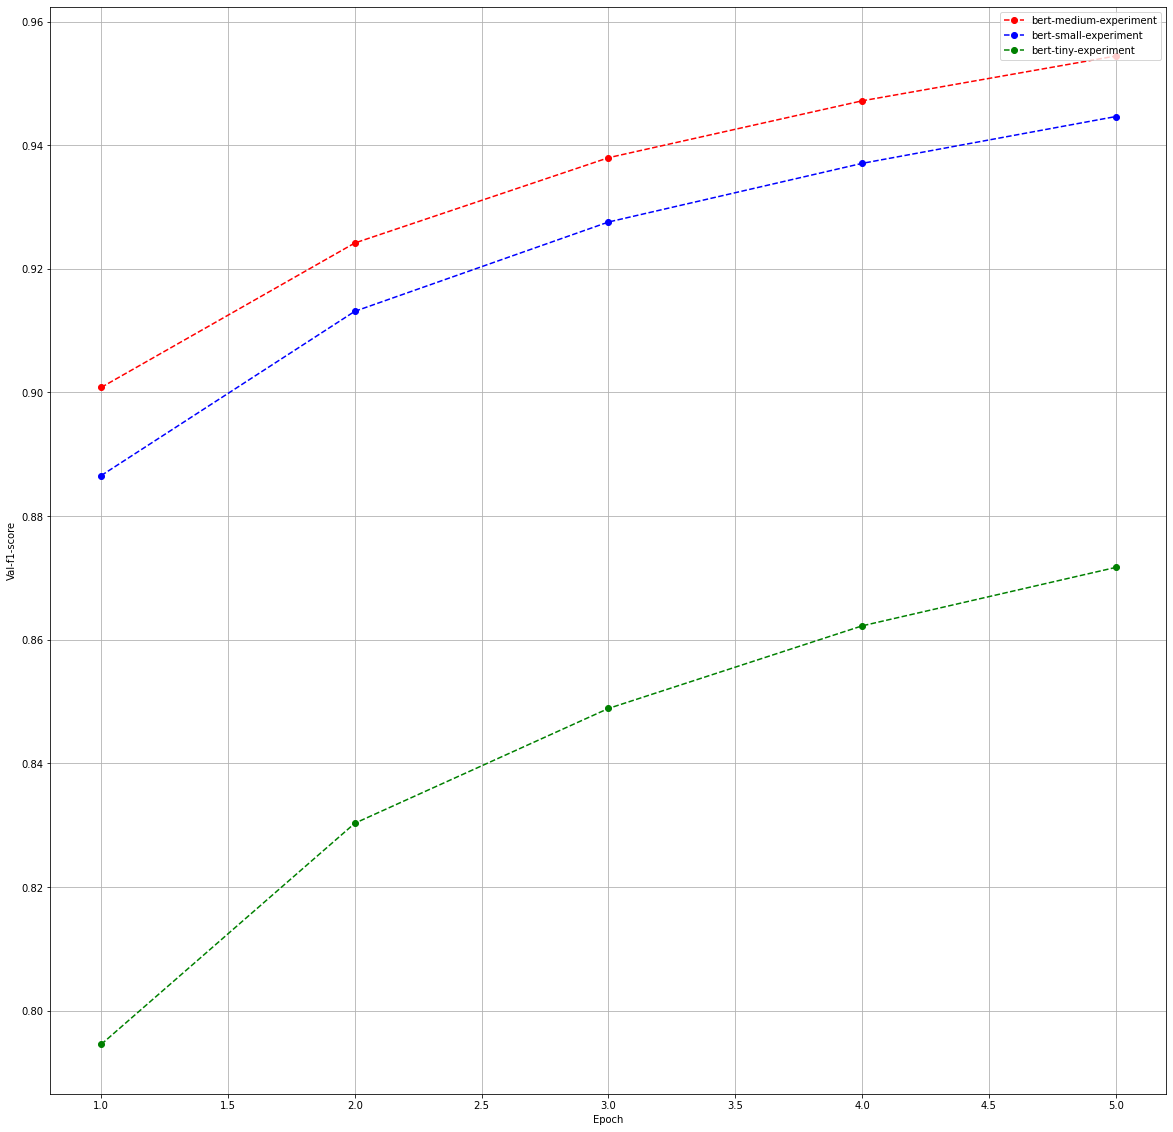

In [26]:
markers_list = ["ro--" , "bo--" , "go--"]
plt.figure(figsize=(20,20))
plt.grid(True)
for marker , file_path in zip(markers_list , pkl_files):
    history = pickle.load(open(file_path , "rb"))
    plt.plot(history["Epoch"] , history["train_f1_score"] , marker , label = file_path.split("/")[-1].split(".")[0])
    plt.xlabel("Epoch")
    plt.ylabel("Val-f1-score")
plt.legend(loc='upper right')
plt.show()